## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../multiscale_HiTS/src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
import ResNet as tnet

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils_MrCAE import *


## Simulation 

In [2]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [3]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

In [4]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 40*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

# Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
# print(Phi.shape)
# plt.plot(Phi[0,0])

In [5]:
# generate data shape (100,500,127,127)
Phi_big = np.zeros((100,500,127,127))
for i in tqdm(range(100)):
    #t start somewhere between zero and 2 pi
    start_t = np.random.rand(1) * 2*np.pi
#     print(start_t)
    t = np.linspace(0, 40*np.pi, 500) + start_t
    xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
    Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
    Phi_big[i] = Phi.T
    
# scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
# print(Phi.shape)


# np.save(data_path, scaled_Phi.T)

  0%|          | 0/100 [00:00<?, ?it/s]

## MrCAE

In [6]:
#normalize 

scaled_Phi = (Phi_big - Phi_big.min()) / (Phi_big.max() - Phi_big.min())
print(scaled_Phi.shape)


(100, 500, 127, 127)


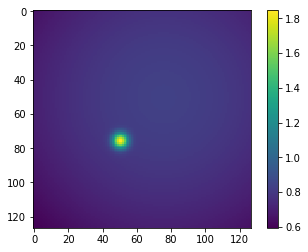

In [7]:
plt.imshow(Phi_big[0,0])
plt.colorbar()

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [8]:
# init model & load data
data_path = '../data/toy1.npy'
model_path = '../model/toy1_space/'
result_path = '../result/toy1_space/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [9]:
# # training
# archs = [[1,2],[1,2],[1,3]]#,3,4],[1,2,3,4],[1,3,5,7]]
# tols = [ 0.001, 0.0005, 0.0001]
# net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
#               tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
#               result_path=result_path, std=0.01, verbose=2)

In [10]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_1
model_L1_0
model_L1_1
model_L2_0


In [13]:
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(data.shape)
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
    
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         print(self)
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            print('L{}_Conv_0'.format(level))
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            print("return encoded")
            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
        print('L{}_Conv_{}'.format(level, i))
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            print('L{}_deConv_0'.format(level))
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
        else:
            i =self.n_filter_groups_each_level['0'] -1
            print("self.n_filter_groups_each_level['0'] -1= ", i)
            print('L{}_deConv_{}'.format(level, i))
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

In [14]:
#encode the data 
model = models['model_L0_0']
encoded_big = torch.zeros((100,500,1,15,15))
data = torch.tensor(scaled_Phi).unsqueeze(2).float()
for i in tqdm(range(100)):
    print(data[i].shape)
    data_this = obtain_data_at_current_level(data[i], 0,3)
    encoded = encode(model, data_this, 0)
    encoded_big[i] = encoded

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
L0_Conv_0
return encoded
torch.Size([500, 1, 127, 127])
torch.Size([

In [15]:
train_data = encoded_big[:90,:,0].flatten(start_dim=2)
val_data = encoded_big[90:,:,0].flatten(start_dim=2)
print(train_data.shape)
print(val_data.shape)

torch.Size([90, 500, 225])
torch.Size([10, 500, 225])


In [21]:
print("inside train_one_timestep")
i=None
j=None
# current_size=16
step_size = 8
# n_inputs = 1
# max_epochs = 1000
# threshold = 1e-5
# print_every=100
# save_every=100
dt=1
n_forward = 5
arch = [225, 225*2, 225*2, 225*2, 225]
batch_size =100
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_0_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

dataset = utils.DataSet(train_data, val_data, val_data, dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_0_8.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

epoch 1000, training loss 0.001508314278908074, validation loss 0.00197303737513721
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.0017734200228005648, validation loss 0.0021863847505301237
epoch 3000, training loss 0.002549842232838273, validation loss 0.0031516533344984055
epoch 4000, training loss 0.0013384668854996562, validation loss 0.0016905289376154542
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.0010223790304735303, validation loss 0.001340828137472272
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.0012486790074035525, validation loss 0.0014287472004070878
epoch 7000, training loss 0.0007729544886387885, validation loss 0.0009554713033139706
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.0013133345637470484, validation loss 0.0013889754191040993
epoch 9000, training loss 0.0005187747301533818, validation loss 0.0006766520091332495
(--> new model saved @ epoch 9000)
epoch 10000, training loss 0.002026133937761187

KeyboardInterrupt: 

In [22]:
# load models
step_sizes = [8,16]
models = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_0_8.pt
model_L0_0_16.pt


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


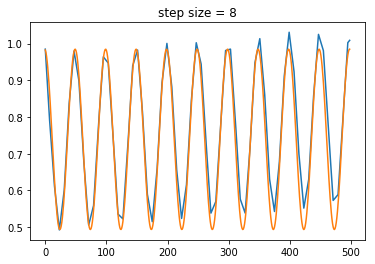

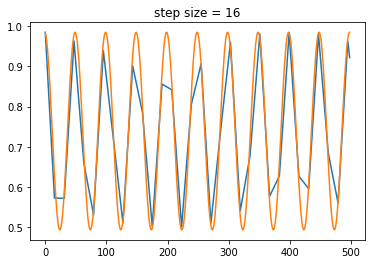

(array([-3.75, -3.5 , -3.25, -3.  , -2.75, -2.5 , -2.25, -2.  , -1.75]),
 <a list of 9 Text yticklabel objects>)

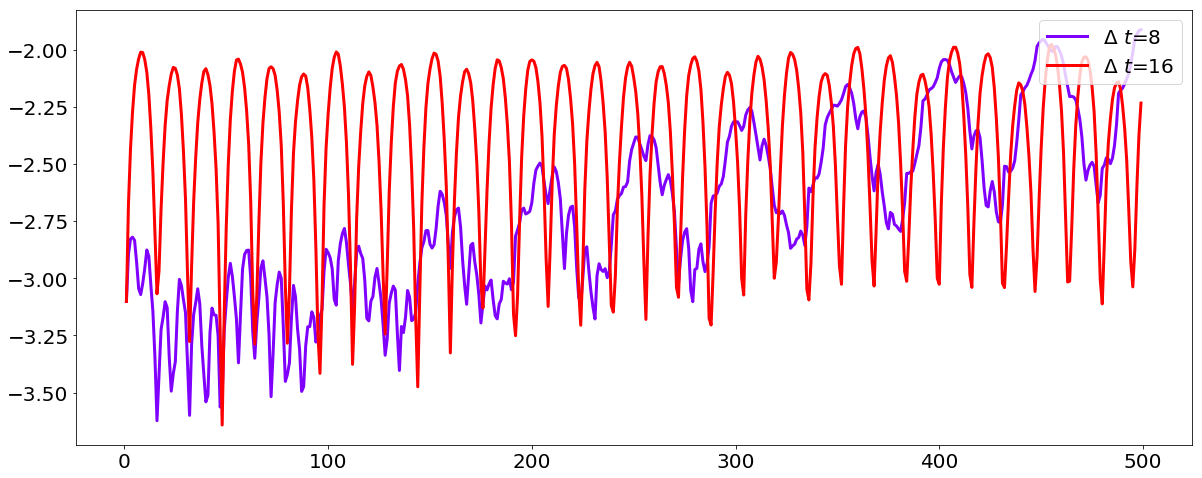

In [25]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

test_data = val_data
ks = [1]
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')


n_steps = 499
for model in tqdm(models):
#     start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    for i in range(1):
        plt.plot(y_preds[1,:,i])
        plt.plot(test_data[1, 1:, i].detach().numpy())
        x = y_preds[1,::model.step_size,i]
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

torch.Size([10, 499, 225])


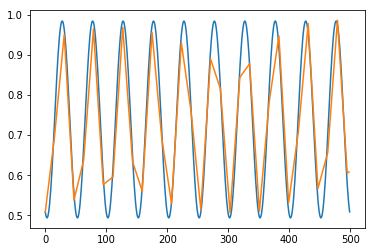

In [24]:
print(y_preds.shape)
plt.plot(test_data[0,:,0].cpu().detach().numpy())
plt.plot(y_preds[0,:,0])

In [30]:
model = models[0]
# y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
print(y_preds.shape)
encoded_t1 = torch.reshape(y_preds, (10,499,15,15))
print(encoded_t1.shape)

torch.Size([10, 499, 225])
torch.Size([10, 499, 15, 15])


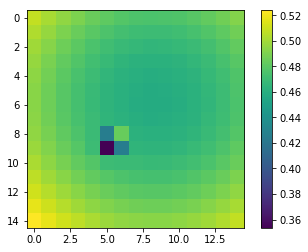

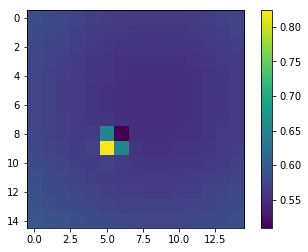

torch.Size([10, 500, 15, 15])
torch.Size([10, 499, 15, 15])


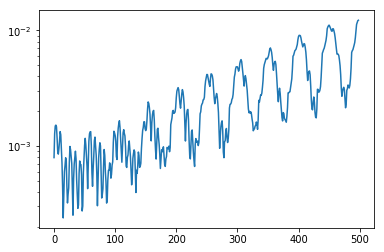

In [47]:
plt.imshow(encoded_t1[0,0])
plt.colorbar()
plt.show()

plt.imshow(encoded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

print(torch.reshape(val_data, (10,500,15,15)).shape)
print(encoded_t1.shape)
mse = np.mean(((torch.reshape(val_data, (10,500,15,15))[:,1:] - encoded_t1)**2).cpu().detach().numpy(), axis=(0,2,3))
plt.semilogy(mse)

(127, 127, 500)
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])
data_this.shape =  torch.Size([500, 1, 31, 31])
return encoded
torch.Size([500, 1, 15, 15])


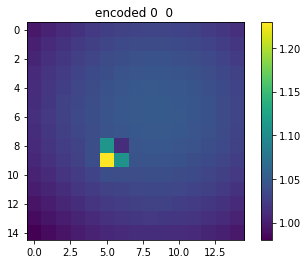

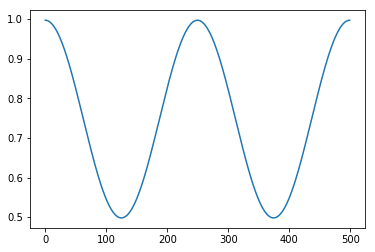

level =  0


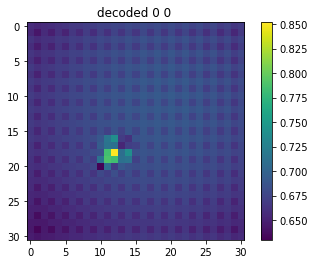

(500,)


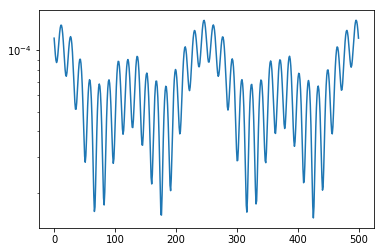

In [31]:
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(data.shape)
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
model = models['model_L0_0']
print(scaled_Phi.shape)
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()[:500]
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
print("data_this.shape = ", data_this.shape )
encoded = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)
print(encoded.shape)

plt.imshow(encoded[0,0].cpu().detach().numpy())
plt.title("encoded 0  0 ")
plt.colorbar()
plt.show()

plt.plot(encoded[:,0,0,0].cpu().detach().numpy())
plt.show()

decoded = model.decode(encoded, 0)

plt.imshow(decoded[0,0].cpu().detach().numpy())
plt.title("decoded 0 0 ")
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2).cpu().detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

In [50]:
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            print('L{}_Conv_0'.format(level))
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            print("return encoded")
            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
        print('L{}_Conv_{}'.format(level, i))
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            print('L{}_deConv_0'.format(level))
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
        else:
            i =self.n_filter_groups_each_level['0'] -1
            print("self.n_filter_groups_each_level['0'] -1= ", i)
            print('L{}_deConv_{}'.format(level, i))
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

{'L0_0': tensor([[[[1.0212, 1.0288, 1.0358,  ..., 1.0503, 1.0456, 1.0399],
          [1.0264, 1.0342, 1.0414,  ..., 1.0561, 1.0513, 1.0456],
          [1.0308, 1.0387, 1.0460,  ..., 1.0610, 1.0561, 1.0503],
          ...,
          [1.0173, 1.0248, 1.0317,  ..., 1.0460, 1.0414, 1.0358],
          [1.0108, 1.0181, 1.0248,  ..., 1.0387, 1.0342, 1.0288],
          [1.0036, 1.0108, 1.0173,  ..., 1.0308, 1.0264, 1.0212]]],


        [[[1.0211, 1.0287, 1.0357,  ..., 1.0502, 1.0455, 1.0399],
          [1.0263, 1.0342, 1.0413,  ..., 1.0560, 1.0513, 1.0455],
          [1.0307, 1.0387, 1.0459,  ..., 1.0609, 1.0560, 1.0502],
          ...,
          [1.0172, 1.0247, 1.0316,  ..., 1.0459, 1.0413, 1.0357],
          [1.0107, 1.0180, 1.0247,  ..., 1.0387, 1.0342, 1.0287],
          [1.0036, 1.0107, 1.0172,  ..., 1.0307, 1.0263, 1.0211]]],


        [[[1.0208, 1.0285, 1.0355,  ..., 1.0499, 1.0452, 1.0396],
          [1.0261, 1.0339, 1.0410,  ..., 1.0558, 1.0510, 1.0452],
          [1.0305, 1.0384, 1.

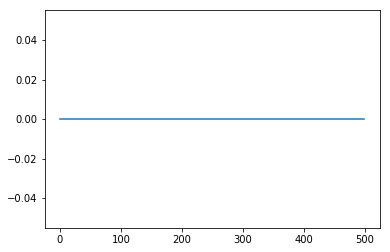

In [59]:
model = models['model_L0_1']

y, all_inputs, all_outputs, all_hidden = model.forward(data_this, 0, query_in_out_each_level=True, query_hidden=True)

plt.plot(all_hidden['L0_1'][:,0,0,0,].cpu().detach().numpy())
print(all_hidden)

torch.Size([500, 1, 127, 127])
data_this.shape =  torch.Size([500, 1, 31, 31])
torch.Size([500, 1, 127, 127])
data_this.shape =  torch.Size([500, 1, 31, 31])
L0_Conv_1
500
self.n_filter_groups_each_level['0'] -1=  1
L0_deConv_1


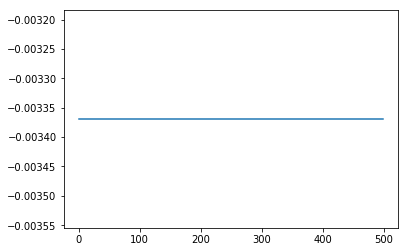

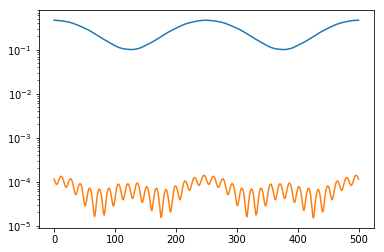

In [54]:
model = models['model_L0_0']
data_this = obtain_data_at_current_level(data, 0,3)
print("data_this.shape = ", data_this.shape )
forwarded_0_0,_,_,_ = model.forward(data_this, 0)

model = models['model_L0_1']
data_this = obtain_data_at_current_level(data, 0,3)
print("data_this.shape = ", data_this.shape )
forwarded,_,_,_ = model.forward(data_this, 0)

# print(encoded.shape)
# plt.imshow(encoded[0,0].cpu().detach().numpy())

encoded = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)
print(len(encoded))
decoded = decode(model, encoded, 0)

plt.plot(decoded[:,0,0,0].cpu().detach().numpy())
# plt.plot(forwarded_0_0[:,0,0,0,].cpu().detach().numpy())
plt.show()
mse = np.mean(((data_this - decoded)**2).cpu().detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)

mse = np.mean(((data_this - forwarded_0_0)**2).cpu().detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)


torch.Size([500, 1, 127, 127])
level =  0
x shape =  torch.Size([500, 1, 31, 31])


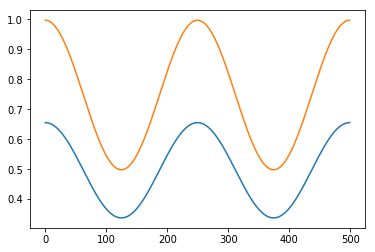

level =  0
torch.Size([500, 1, 127, 127])
data_this.shape =  torch.Size([500, 1, 31, 31])
L0_Conv_1
torch.Size([500, 1, 15, 15])
self.n_filter_groups_each_level['0'] -1=  1
L0_deConv_1


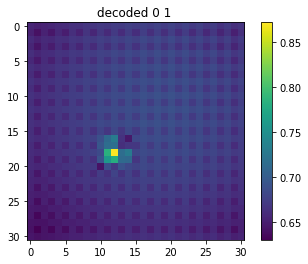

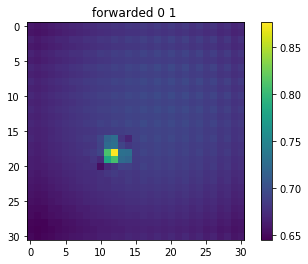

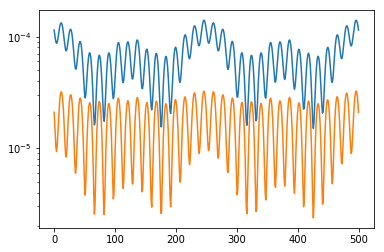

In [38]:
#predicting with the 1 widening phase  


model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()[:500]
data_this = obtain_data_at_current_level(data, 0,3)
encoded = model.encode(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)


plt.plot(data_this[:,0,0,0].cpu().detach().numpy())
plt.plot(encoded[:,0,0,0].cpu().detach().numpy())
plt.show()

decoded_0_0 = model.decode(encoded, 0)

# plt.imshow(decoded_0_0[0,0].cpu().detach().numpy())
# plt.title("decoded 0 0 ")
# plt.colorbar()
# plt.show()

model = models['model_L0_1']
data_this = obtain_data_at_current_level(data, 0,3)
print("data_this.shape = ", data_this.shape )
encoded = encode(model,data_this, 0)#, query_in_out_each_level=False, query_hidden=False)
print(encoded.shape)

# plt.imshow(encoded[0,0].cpu().detach().numpy())
# plt.title("encoded 0  0 ")
# plt.colorbar()
# plt.show()

# print(encoded.shape)
# plt.plot(encoded[:,0,8,5].cpu().detach().numpy())
# plt.show()
# # hjk
# # print(encoded[0,0])

# plt.plot(encoded[:,0,0,0].cpu().detach().numpy())
# plt.show()

decoded_0_1 = decode(model,encoded, 0, y=decoded_0_0)

plt.imshow(decoded_0_1[0,0].cpu().detach().numpy())
plt.title("decoded 0 1 ")
plt.colorbar()
plt.show()

forwarded,_,_,_ = model.forward(data_this, 0)
plt.imshow(forwarded[0,0].cpu().detach().numpy())
plt.title("forwarded 0 1 ")
plt.colorbar()
plt.show()


mse = np.mean(((data_this - decoded)**2).cpu().detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)

mse = np.mean(((data_this - forwarded)**2).cpu().detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)


torch.Size([500, 1, 127, 127])
i  =  1
torch.Size([500, 1, 127, 127])
i  =  1
500


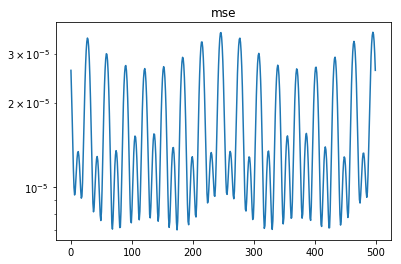

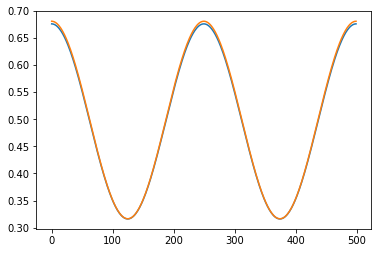

In [32]:


data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 1,5)
model = models['model_L1_0']
y_0, all_inputs, all_outputs, all_hidden = model.forward(data_this, 1)
model = models['model_L1_1']
data_this = obtain_data_at_current_level(data, 1,5)
y, all_inputs, all_outputs, all_hidden = model.forward(data_this, 1, True, True)

encoded = encode(model, data_this, 1)

print(len(encoded))

decoded = decode(model, encoded, 1, y_0)

mse = np.mean(((decoded - y)**2).cpu().detach().numpy(), axis=(1,2,3))
plt.title("mse")
plt.semilogy(mse)
plt.show()

plt.plot(y[:,0,0,0].cpu().detach().numpy())
plt.plot(decoded[:,0,0,0].cpu().detach().numpy())

dict_keys(['L0_0', 'L0_1'])
torch.Size([500, 1, 15, 15])
torch.Size([500, 1, 15, 15])


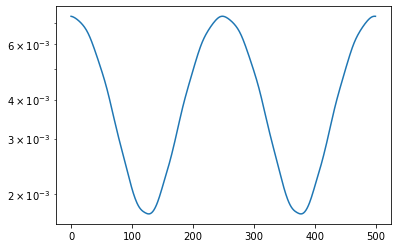

In [99]:
print(all_hidden.keys())
print(all_hidden['L0_0'].shape)
print(all_hidden['L0_1'].shape)

# mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
# plt.plot(mse)
# mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
# plt.semilogy(mse)
# plt.show()
mse = np.mean(((encoded_0_0 - all_hidden['L0_0'])**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)

plt.show()


level =  0
x shape =  torch.Size([500, 1, 31, 31])
level =  0


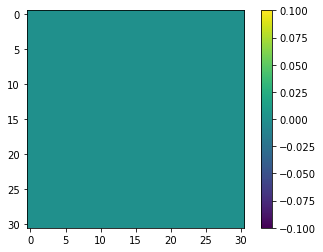

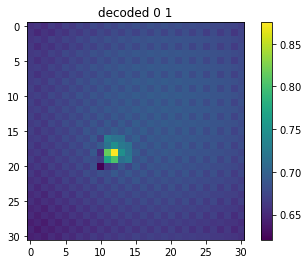

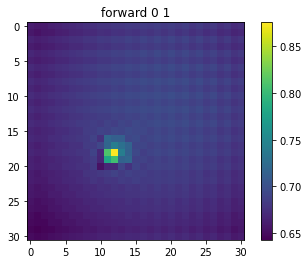

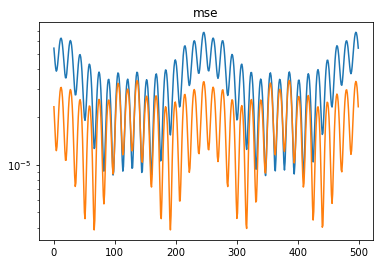

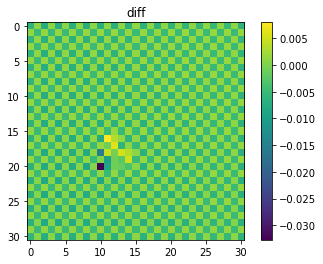

In [64]:
model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_0 = model.encode(data_this, 0)
decoded_0_0 = model.decode(encoded_0_0, 0)

forward_0_0,_,_,_ = model.forward(data_this, 0)

plt.imshow((forward_0_0 - decoded_0_0)[0,0].detach().numpy())
plt.colorbar()
plt.show()

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_1 = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

decoded_0_1 = decode(model, encoded_0_1, 0, forward_0_0)

forward_0_1,_,_,_ = model.forward(data_this, 0)

plt.imshow(decoded_0_1[0,0].detach().numpy())
plt.title("decoded 0 1")
plt.colorbar()
plt.show()

plt.imshow(forward_0_1[0,0].detach().numpy())
plt.title("forward 0 1")
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse)
mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)
plt.title("mse")
plt.show()

diff = (decoded_0_1 - forward_0_1)
plt.imshow(diff[0,0].detach().numpy())
plt.title("diff")
plt.colorbar()
# print(encoded.shape)
# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()
# for i in range(15):
#     for j in range(15):
#         if torch.abs(encoded_0_1[0,0,i,j]) >0:
#             plt.plot(encoded_0_1[:,0,i,j].detach().numpy())
# #             plt.plot(encoded_0_0[:,0,i,j].detach().numpy())
# #             plt.show()
# #             hjk

level =  0
x shape =  torch.Size([500, 1, 31, 31])
level =  0


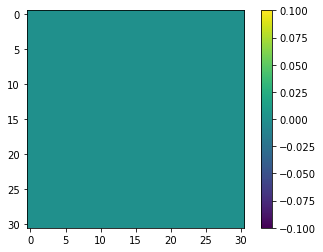

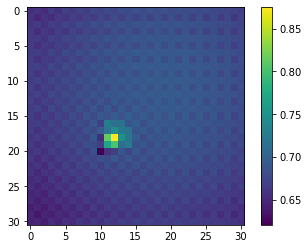

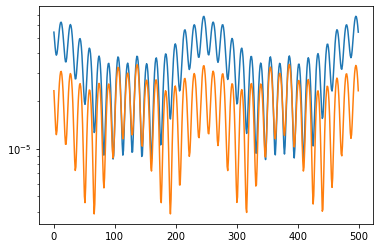

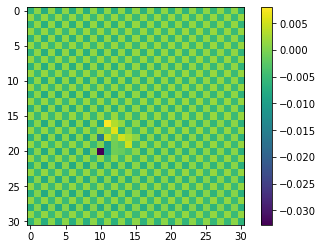

In [63]:
model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_0 = model.encode(data_this, 0)
decoded_0_0 = model.decode(encoded_0_0, 0)

forward_0_0,_,_,_ = model.forward(data_this, 0)

plt.imshow((forward_0_0 - decoded_0_0)[0,0].detach().numpy())
plt.colorbar()
plt.show()

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_1 = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

decoded_0_1 = decode(model, encoded_0_1, 0, forward_0_0)

forward_0_1,_,_,_ = model.forward(data_this, 0)

plt.imshow(decoded_0_1[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse)
mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)
plt.show()

diff = (decoded_0_1 - forward_0_1)
plt.imshow(diff[0,0].detach().numpy())
plt.colorbar()
# print(encoded.shape)
# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()
# for i in range(15):
#     for j in range(15):
#         if torch.abs(encoded_0_1[0,0,i,j]) >0:
#             plt.plot(encoded_0_1[:,0,i,j].detach().numpy())
# #             plt.plot(encoded_0_0[:,0,i,j].detach().numpy())
# #             plt.show()
# #             hjk

level =  0
x shape =  torch.Size([500, 1, 31, 31])
encoded.shape =  torch.Size([500, 1, 15, 15])
level =  0
torch.Size([499, 1, 31, 31])
datathis =  torch.Size([500, 1, 31, 31])
level =  0
x shape =  torch.Size([500, 1, 31, 31])
encoded.shape =  torch.Size([500, 1, 15, 15])
level =  0
level =  1
x shape =  torch.Size([500, 1, 63, 63])
encoded.shape =  torch.Size([500, 1, 31, 31])
level =  1
(499,)


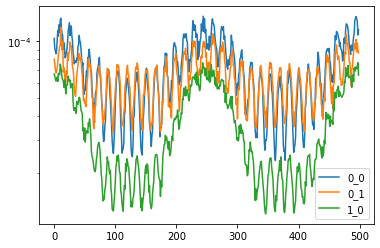

In [71]:
model = models['model_L0_0']
data_this = obtain_data_at_current_level(data, 0,3)
predicted = model.predict_in_middle(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))

# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()

# plt.plot(encoded[:,0,0,0].detach().numpy())
# plt.show()

# decoded = model.decode(encoded, 0)

# plt.imshow(decoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()

print(predicted.shape)
print("datathis = ", data_this.shape)
mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse,label = "0_0")

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
predicted = model.predict_in_middle(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)


mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse,label = "0_1")


model = models['model_L1_0']
data_this = obtain_data_at_current_level(data, 1,3)
predicted = model.predict_in_middle(data_this, 1)#, query_in_out_each_level=False, query_hidden=False)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse,label = "1_0")


plt.legend()
print(mse.shape)
# plt.semilogy(mse)

level =  1
x shape =  torch.Size([500, 1, 63, 63])
torch.Size([500, 1, 31, 31])


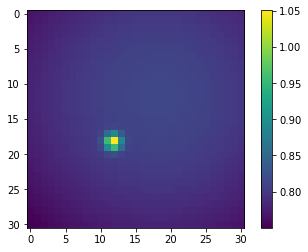

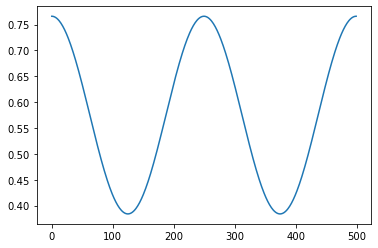

level =  1


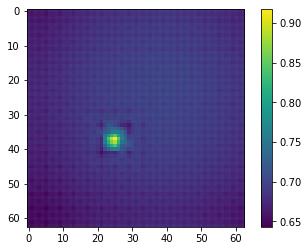

(500,)


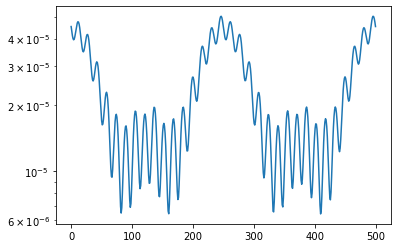

In [11]:
model = models['model_L1_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
step_size = 1
data_this = obtain_data_at_current_level(data, 1,3)[::step_size]
encoded = model.encode(data_this, 1)#, query_in_out_each_level=False, query_hidden=False)
print(encoded.shape)

plt.imshow(encoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.plot(encoded[:,0,0,0].detach().numpy())
plt.show()

decoded = model.decode(encoded, 1)

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

In [12]:
print(torch.min(torch.abs(encoded)))

tensor(0.0078, grad_fn=<MinBackward1>)


level =  1
x shape =  torch.Size([500, 1, 63, 63])
encoded.shape =  torch.Size([500, 1, 31, 31])
level =  1
torch.Size([499, 1, 63, 63])


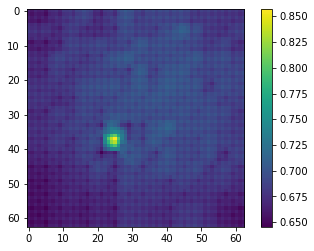

(499,)
(499,)


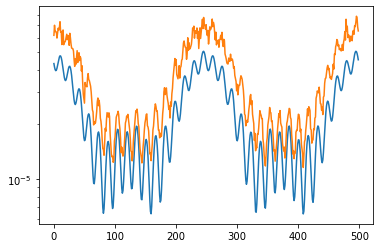

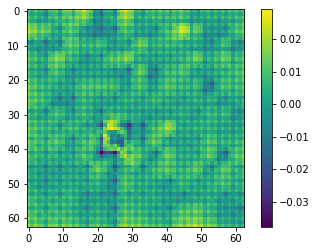

In [13]:
predicted = model.predict_in_middle(data_this, 1)
print(predicted.shape)
plt.imshow(predicted[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2)[1:].detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)
plt.show()
plt.imshow((predicted - data_this[1:])[0,0].detach().numpy() )
plt.colorbar()
plt.show()

In [ ]:
data_this = obtain_data_at_current_level(data, 1,3)
print(decoded.shape)
print(data_this.shape)

mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

In [ ]:
plt.plot(encoded[:,0,0,0].detach().numpy())
x1 = np.arange(500)/360
x2 = encoded[:,0,0,0].detach().numpy()

In [ ]:
from scipy import optimize
def form(x, a, b, c, d):
    return a*np.cos(b*x + c) + d

param, covariance = optimize.curve_fit(form, x1, x2)
plt.scatter(x1*360, x2, label='data')
plt.ylim(x2.min(), x2.max())
plt.plot(x1*360, form(x1, *param), 'b-', label="predicted")
plt.legend()
plt.show()

## Results

In [ ]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

In [ ]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

In [ ]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))